1. Download the Data1 and Random2
catalogues. The data points consists in ND galaxies from
SDSS DR7. The first three columns are the positions (in Mpc/h) and the last column is
the weight. We will forget about the weight here. The random catalogue contains uniformly
distributed points following the same survey shape. Since it is quite large, let us randomly
select NR = 3Ngal points.

In [1]:
import pandas as pd
import ssl

ssl._create_default_https_context = ssl._create_unverified_context
tables = pd.read_csv("https://bitbucket.org/csabiu/kstat2/raw/77989875594f72a521b20e2e7070429a41d5d216/example/test.gal")
Data = pd.read_csv("https://bitbucket.org/csabiu/kstat2/raw/77989875594f72a521b20e2e7070429a41d5d216/example/test.gal",delim_whitespace='True') # sep='\b',

Data.describe()

,-4.3673441e+02,1.2729111e+03,1.1092042e+03,6.1588812e-01
count,207245.000000,207245.000000,207245.000000,207245.000000
mean,-1336.190301,-241.381122,687.169092,0.202459
std,478.998901,1208.424744,536.154810,0.113236
min,-2540.740400,-2337.768700,-155.498370,0.109613
25%,-1700.580900,-1402.485100,133.632030,0.127004
50%,-1359.077600,-382.156000,750.227890,0.155137
75%,-959.751420,920.033980,1164.621800,0.241856
max,-162.354680,2209.031000,2070.940200,2.357050


In [2]:
ssl._create_default_https_context = ssl._create_unverified_context
tables = pd.read_csv("https://bitbucket.org/csabiu/kstat2/raw/77989875594f72a521b20e2e7070429a41d5d216/example/test.gal")
rand_cat = pd.read_csv("https://bitbucket.org/csabiu/kstat2/raw/77989875594f72a521b20e2e7070429a41d5d216/example/test.ran",delim_whitespace='True')

rand_cat.describe()

,-1.5245353e+03,2.3734192e+02,1.0598991e+03,1.2498690e-01
count,3.499985e+06,3.499985e+06,3.499985e+06,3.499985e+06
mean,-1.319909e+03,-2.358549e+02,6.821171e+02,1.874112e-01
std,4.854787e+02,1.226985e+03,5.333671e+02,9.019949e-02
min,-2.540534e+03,-2.343056e+03,-1.590689e+02,1.200992e-01
25%,-1.691889e+03,-1.425846e+03,1.337097e+02,1.252647e-01
50%,-1.332170e+03,-3.756794e+02,7.332702e+02,1.475979e-01
75%,-9.375114e+02,9.581864e+02,1.154136e+03,2.150418e-01
max,-1.576823e+02,2.222463e+03,2.103222e+03,5.646779e-01


In [3]:
import numpy as np

cho_rx = np.random.RandomState(111).choice(rand_cat["-1.5245353e+03"], 207245*3, replace=False)
cho_ry = np.random.RandomState(111).choice(rand_cat["2.3734192e+02"], 207245*3, replace=False)
cho_rz = np.random.RandomState(111).choice(rand_cat["1.0598991e+03"], 207245*3, replace=False)

data_arr = np.vstack((Data["-4.3673441e+02"], Data["1.2729111e+03"], Data["1.1092042e+03"])).T
cho_rarr = np.vstack((cho_rx, cho_ry, cho_rz)).T

print(data_arr.shape)
print(cho_rarr.shape)

(207245, 3)
(621735, 3)


2. Using scipy.spatial.KDTree, build two trees: one tree containing the Data and and one
for the the Random catalogues. You will need a version >1.6. If you use google colab,
you will need to run !pip install scipy --upgrade and restart the kernel. use print
(scipy.__version__) to check your scipy version.

In [4]:
from scipy.spatial import KDTree

data_tree = KDTree(data_arr)
rand_tree = KDTree(cho_rarr)

print(data_tree)
print(rand_tree)

3. Calculate the 2pcf using the following estimator of the 2pcf
ξ(r) = DD/
RR
− 1 (1)
for Nbin bins of separation r, where DD stands for the number of data-data pairs and RR
the number of Random-Random pairs. Note that DD and RR should be normalized by the
number of pairs ND,R(ND,R −1). The scipy.KDTree class has a method to count neighbours,
read the doc attentively! Note: you may want to do so with a smaller number of points at
first, say 100,000 galaxies and 300,000 random, and see the influence of the binning. When
you are satisfied, you can use the whole dataset.

In [18]:
#n = bins of separation r, bin radius
n = np.linspace(0,200,200)

P_DD = data_tree.count_neighbors(data_tree,n)
P_RR = rand_tree.count_neighbors(rand_tree,n)
P_DR = data_tree.count_neighbors(rand_tree,n)

n_DD = len(data_arr)*(len(data_arr)-1)/2
n_RR = len(cho_rarr)*(len(cho_rarr)-1)/2
n_DR = len(data_arr)*len(cho_rarr)

DD = P_DD/n_DD
RR = P_RR/n_RR
DR = P_DR/n_DR


4. Plot the correlation function. What can you say about it?

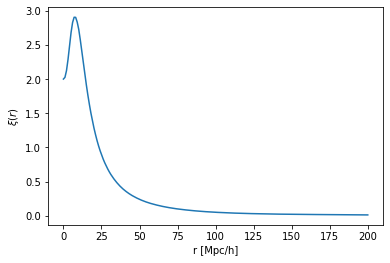

In [26]:
import matplotlib.pyplot as plt

Xi = DD/RR -1 

fig, ax = plt.subplots(1)
ax.plot(n,Xi)
ax.set_ylabel("$\\xi(r)$")
ax.set_xlabel("r [Mpc/h]")
#ax.set_xscale('log')
plt.show()

# radius at 0 Mpc/h to about 13 Mpc/h , the density of galaxy in space is increasing.
# and after 13 Mpc/h the density is decreasing.


5. (Bonus) On the same plot, plot error-bars using the Jackknife method to estimate the variance
in each bin. Note: since the number of data and random points is large, you may want to do
jackknife by block: divide the total domain into N3 cubes, and remove one cube at a time instead of removing one data point at a time. 

6. (Bonus) In practice, in cosmology, we do not use the natural estimator DD/RR − 1. One of
the most used estimators is the Landy & Szalay (1993) estimator
ξLS(r) = (DD − 2DR + RR)/
RR
− 1.
(2)
On the same plot, compare the LS estimator.

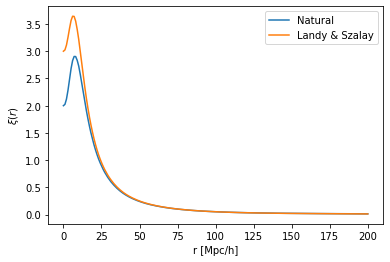

In [23]:

Xi_N = DD/RR -1
Xi_LS = (DD -2*DR + RR)/(RR) -1 

fig, ax = plt.subplots(1)
ax.plot(n,Xi_N, label = "Natural")
ax.plot(n,Xi_LS, label = "Landy & Szalay")
ax.set_ylabel("$\\xi(r)$")
ax.set_xlabel("r [Mpc/h]")
#ax.set_yscale("log")
#ax.set_xscale('log')
ax.legend()
plt.show()